In [1]:
from scipy import optimize
import numpy as np
from math import sqrt, factorial
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import yfinance as yf
from arch import arch_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

### Initial Data Cleanup (dropping options with volume < 100) & segregating the call & put data 

In [2]:
tradeDate = datetime(2004, 3, 18)
expiryDate = datetime(2004, 4, 17)

# load the relevant optionsdata corresponding to our assigned date 18-03-2004
optionsData = pd.read_csv("input resources/OptionData.csv")
# optionsData.head()

# data cleanup and segregation of call & put options
optionsData.rename(columns={'Trade dAte': 'Trade Date', 'Strike x 1000': 'Strike'}, inplace=True)
optionsData['Strike'].replace(optionsData['Strike'].values, [x/1000 for x in optionsData['Strike'].values], \
                              inplace=True)
optionsData['Trade Date'] = pd.to_datetime(optionsData['Trade Date'], \
                                           infer_datetime_format=True, format='%d/%m/%Y')
optionsData['Expiry Date'] = pd.to_datetime(optionsData['Expiry Date'], \
                                            infer_datetime_format=True, format='%d/%m/%Y')
optionsDataCleaned = optionsData[optionsData.Volume >= 100]
optionsDataCleaned.reset_index(inplace=True, drop=True)

# call data
callData = optionsDataCleaned[optionsDataCleaned['Put=1 Call=0'] == 0]
callData = callData[callData.columns.drop('Put=1 Call=0')]
callData.reset_index(inplace=True, drop=True)
callData.to_csv(path_or_buf='output resources/CallData.csv', index=False)

# put data
putData = optionsDataCleaned[optionsDataCleaned['Put=1 Call=0'] == 1]
putData = putData[putData.columns.drop('Put=1 Call=0')]
putData.reset_index(inplace=True, drop=True)
putData.to_csv(path_or_buf='output resources/PutData.csv', index=False)

---

### Q1 (a) Obtaing the appropriate interest rate 

In [3]:
# load the Zero Rate data for our trade date
zeroRateData = pd.read_csv("input resources/ZeroCurve.csv")
zeroRateData['Date'] = pd.to_datetime(zeroRateData['Date'], infer_datetime_format=True, format='%d/%m/%Y')
zeroRateData = zeroRateData[zeroRateData.Date == tradeDate]
zeroRateData.head()

# pick the most relevant rate that corresponds to the duration of our option till expiration
timeToExpiryDays = 21 # approx number of trading days between trade date and expiry date
timeToExpiryAnnualised = timeToExpiryDays / 252 # annualised
zeroRate = (zeroRateData.iloc[(zeroRateData.Days - timeToExpiryDays).abs().argmin()]['Rate']) / 100
print("Time to option expiry (annualised): {:.4f}".format(timeToExpiryAnnualised))
print("\nRelevant zero rate: {:.4f} %".format(zeroRate * 100))

Time to option expiry (annualised): 0.0833

Relevant zero rate: 1.0820 %


---

### Q1 (b) Obtain the relevant dividend yield rate for the SPX500 

In [4]:
# load the SPX Div Yield data for our trade date
divYieldData = pd.read_csv("input resources/SPXDivYield.csv")
divYieldData['Date'] = pd.to_datetime(divYieldData['Date'], infer_datetime_format=True, format='%d/%m/%Y')
divYield = (divYieldData[divYieldData.Date == tradeDate]['Rate'].item()) / 100
print("Relevant dividend yield: {:.4f} %".format(divYield * 100))

Relevant dividend yield: 1.6323 %


---

### Q1 (c) Price the option using BSM formula and compare to the mid-point of corresponding option bid/ask spread.

In [5]:
# load the SPX Daily data for our trade date
spxData = yf.download('^GSPC', start=datetime(1950, 1, 3), end=expiryDate, interval='1d')
spxData.reset_index(inplace=True)
spxSpot = spxData.loc[spxData.Date == tradeDate]['Adj Close'].item()
print("\nSpot Price of SPX on trade date: {:.4f}".format(spxSpot))

[*********************100%***********************]  1 of 1 completed

Spot Price of SPX on trade date: 1122.3199


Fetch call & put options with strike ~ spot price of the underlying (SPX) on our trade date (ATM)

In [6]:
callAtmData = callData.iloc[(callData['Strike'] - spxSpot).abs().argmin()]
putAtmData = putData.iloc[(putData['Strike'] - spxSpot).abs().argmin()]

In [7]:
class BsOption:
    '''
    The BsOption object is used to calculate the option price
    for both calls and puts using the BS formula

    Args:
        spot (float): Spot price of underlying
        strike (float): Strike price of option
        time (float): Time to option expiry (annualised)
        intRate (float): Risk-free interest rate
        sigma (float): Implied volatility of the underlying (annualised)
        divY (float): Dividend yield of underlying (annualised)

    Attributes:
        S (float): This is where we store spot
        K (float): This is where we store strike
        T (float): This is where we store time to expiry
        r (float): This is where we store int rate
        sigma (float): This is where we store Imp vol
        q (float): This is where we store div yield
    '''
    
    def __init__(self, spot, strike, time, intRate, sigma, divY=0):
        self.S = spot
        self.K = strike
        self.T = time
        self.r = intRate 
        self.sigma = sigma
        self.q = divY
        
    
    @staticmethod
    def N(x):
        '''
        Returns CDF
        '''
        return norm.cdf(x)
    
    @staticmethod
    def N_prime(x):
        '''
        Returns PDF
        '''
        return norm.pdf(x)
        
    @property
    def params(self):
        return {'S': self.S, 
                'K': self.K, 
                'T': self.T, 
                'r':self.r,
                'q':self.q,
                'sigma':self.sigma}
    
    def d1(self):
        '''Computes the d1 element of BS formula

        Returns:
            (float): value of d1 in the BS formula
        '''
        return (np.log(self.S/self.K) + (self.r -self.q + (self.sigma**2/2))*self.T) \
                                / (self.sigma*np.sqrt(self.T))
    
    def d2(self):
        '''Computes the d2 element of BS formula

        Returns:
            (float): value of d2 in the BS formula
        '''
        return self.d1() - self.sigma*np.sqrt(self.T)
    
    def _call_value(self):
        '''Computes the call option price using the BS formula

        Returns:
            (float): call option price
        '''
        return self.S*np.exp(-self.q*self.T)*self.N(self.d1()) - \
                    self.K*np.exp(-self.r*self.T) * self.N(self.d2())
                    
    def _put_value(self):
        '''Computes the put option price using the BS formula

        Returns:
            (float): put option price
        '''
        return self.K*np.exp(-self.r*self.T) * self.N(-self.d2()) -\
                self.S*np.exp(-self.q*self.T)*self.N(-self.d1())
    
    def price(self, optType = 'C'):
        '''Returns the corresponding option price computed using BS formula

        Args:
            optType (str): option type (C for call, P for put)

        Raises:
            ValueError: Unrecognized option type

        Returns:
            (float): option price
        '''
        if optType == 'C':
            return self._call_value()
        if optType == 'P':
            return self._put_value()
        else:
            raise ValueError('Unrecognized option type: please input either C for call or P for put')
            
    def delta(self, optType = 'C'):
        '''Returns the greek Delta value based on appropriate formula

        Args:
            optType (str): option type (C for call, P for put)

        Raises:
            ValueError: Unrecognized option type

        Returns:
            (float): Delta value
        '''
        if optType == 'C':
            return np.exp(-self.q*self.T)*self.N(self.d1())
        if optType == 'P':
            return -np.exp(-self.q*self.T)*self.N(-self.d1())
        else:
            raise ValueError('Unrecognized option type: please input either C for call or P for put')
            
    def gamma(self):
        '''Returns the greek Gamma value based on appropriate formula (common for both call & put options)
        
        Returns:
            (float): Gamma value
        '''
        return np.exp(-self.q*self.T)*self.N_prime(self.d1()) / (self.S*self.sigma*np.sqrt(self.T))

In [8]:
# compute the BS price for call ATM option
callAtmPrice = BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, 
                        intRate=zeroRate, divY=divYield, sigma=callAtmData['Implied Vol']).price(optType='C')
print("BS option price for ATM call: {:.4f}".format(callAtmPrice))

# compute Call ATM bid-ask mid value
callAtmBidAskMid = (callAtmData['Bid Price'] + callAtmData['Ask Price']) / 2
print("\nBid-Ask mid point value for ATM call option: {:.4f}".format(callAtmBidAskMid))

BS option price for ATM call: 22.9115

Bid-Ask mid point value for ATM call option: 22.0500


In [9]:
# compute the BS price for put ATM option
putAtmPrice = BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiryAnnualised, intRate=zeroRate, divY=divYield, sigma=putAtmData['Implied Vol']).price(optType='P')
print("BS option price for ATM put: {:.4f}".format(putAtmPrice))

# compute put ATM bid-ask mid value
putAtmBidAskMid = (putAtmData['Bid Price'] + putAtmData['Ask Price']) / 2
print("\nBid-Ask mid point value for ATM put option: {:.4f}".format(putAtmBidAskMid))

BS option price for ATM put: 19.7791

Bid-Ask mid point value for ATM put option: 16.5500


---

### Q1 (d) Find an implied volatility for which the B-S-M formula price matches the midpoint of the Option Metrics Bid/Ask spread exactly

We'll use the Newton Raphson Method, the fastest root-finding approximation method, to compute the implied volatility for which the BSM price matches exactly with the mid-point of ATM call bid-ask spread.

#### Newton Raphson Method:

 $\text{It's given by the equation, }$
 $$\displaystyle{x}_{n+1} = {x}_{n} - \frac{f({x}_{n})} {f^{'}({x}_{n})}$$
 
 $\text{where}$ $\displaystyle f({x}_{n})$ $\text{is a function that is the theoretical (BS) option price – the actual option price,}$ 
 $\displaystyle f^{'}({x}_{n})$ $\text{is the Vega, or the option price sensitivity to implied volatility}$
 $$\displaystyle f^{'}({x}_{n}) = {S}{N}^{'}(d_{1})\sqrt{T}$$

In [10]:
def compute_sigma_newton(S, K, r, t, q, actual_price, c_p, maxIterations=1000, diffThreshold=0.01):
    # assume the starting sigma to be 0.5, which is just an arbitrary number
    _sigma = 0.5 
    
    for i in range(maxIterations):
        _bsOptionObj = BsOption(spot=S, strike=K, time=t, intRate=r, divY=q, sigma=_sigma)
        _bs_price = _bsOptionObj.price(optType=c_p)
        _diff = actual_price - _bs_price
        _pdf = _bsOptionObj.N_prime(_bsOptionObj.d1())
        _vega = S * _pdf * sqrt(t)
        if abs(_diff) < diffThreshold:
            return _sigma
        _sigma += _diff/_vega
        
    return _sigma

In [11]:
# compute the implied vol for ATM call option
callAtmCalSigma = compute_sigma_newton(S=spxSpot, K=callAtmData.Strike,  
                                                                  r=zeroRate, t=timeToExpiryAnnualised, 
                                                                q=divYield, actual_price=callAtmBidAskMid, c_p='C')
print("Computed implied vol for ATM call: {:.4f} %".format(callAtmCalSigma * 100))
print("\nActual implied vol used for ATM call BS price: {:.4f} %".format(callAtmData['Implied Vol'] * 100))

Computed implied vol for ATM call: 16.3938 %

Actual implied vol used for ATM call BS price: 17.0580 %


In [12]:
# compute the implied vol for ATM put option
putAtmCalSigma = compute_sigma_newton(S=spxSpot, K=putAtmData.Strike,  
                                                                  r=zeroRate, t=timeToExpiryAnnualised, 
                                                                q=divYield, actual_price=putAtmBidAskMid, c_p='P')
print("Computed implied vol for ATM put: {:.4f} %".format(putAtmCalSigma * 100))
print("\nActual implied vol used for ATM put BS price: {:.4f} %".format(putAtmData['Implied Vol'] * 100))

Computed implied vol for ATM put: 13.5242 %

Actual implied vol used for ATM put BS price: 16.0270 %


---

### Q2 (a) The sensitivity of the Black-Scholes option price to changes in volatility, σ (from σ =5% to σ =80% in steps of 5%)

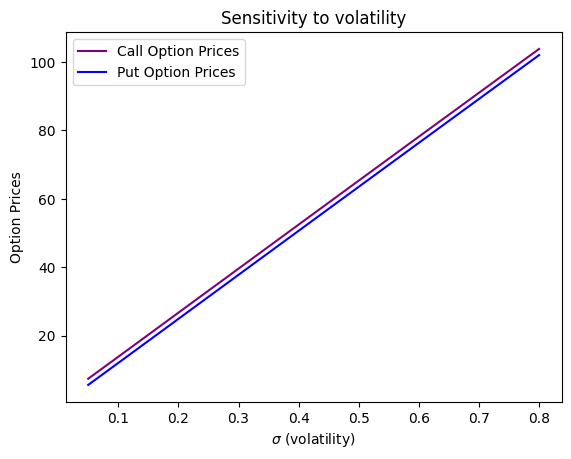

In [13]:
# Range of values from 5% to 80% in steps of 5%
sigmaRange = np.arange(0.05, 0.85, 0.05)

callPricesForSigma = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=zeroRate, divY=divYield, sigma=sig) 
                      .price(optType='C') for sig in sigmaRange]
putPricesForSigma = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=zeroRate, divY=divYield, sigma=sig) 
                      .price(optType='P') for sig in sigmaRange]

# plot the sigma values against call & put prices
plt.plot(sigmaRange, callPricesForSigma, label='Call Option Prices', color='purple')
plt.plot(sigmaRange, putPricesForSigma, label='Put Option Prices', color='blue')
plt.xlabel('$\sigma$ (volatility)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to volatility')
plt.legend()

As we would expect, when we hold the other variables constant, and increase the volatility parameter both calls and puts increase in value, in what appears to be a linear fashion as shown below.

To understand why the calls value seems to be greater than the put with respect to volatility, change the interest rate 'r' to 0 and notice that the curve coincide exactly. Rather than making plots for the effect on interest rates, we can deduce from this that an increase in interest rates increases the value of calls and decreases the value of puts. 

---


### Q2 (b) Using delta and gamma in a Taylor series expansion, superimpose a plot of the projected price around the price of your option using a grid of price changes in the range -30% to +30%.

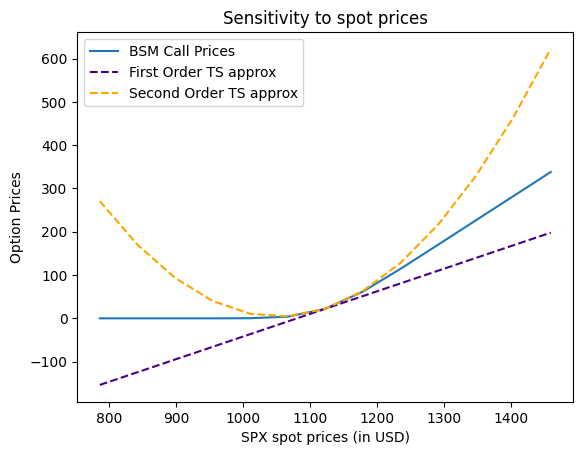

In [14]:
q2PctRange = np.round(np.arange(-0.3, 0.35, 0.05), decimals=2)
q2SpxSpotRange = [(1+pct) * spxSpot for pct in q2PctRange]

# compute BSM option prices (ATM call) over the defined SPX spot price range 
bsmCallPrices = [BsOption(spot=spot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, intRate=zeroRate, 
                          divY=divYield, sigma=callAtmCalSigma).price(optType='C') for spot in q2SpxSpotRange]

# Taylor Series approximations (for ATM call option)
bsmObject = BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, intRate=zeroRate, 
                          divY=divYield, sigma=callAtmCalSigma)
bsmValueAtSpot = bsmObject.price(optType='C')
deltaAtSpot = bsmObject.delta(optType='C')
gammaAtSpot = bsmObject.gamma()
firstDerTS = [bsmValueAtSpot + (spot-spxSpot)*deltaAtSpot for spot in q2SpxSpotRange]
secondDerTS = [bsmValueAtSpot + (spot-spxSpot)*deltaAtSpot + (((spot-spxSpot)**2)/factorial(2))*gammaAtSpot
               for spot in q2SpxSpotRange]


# plot option prices against spot prices in the defined range
plt.plot(q2SpxSpotRange, bsmCallPrices, label='BSM Call Prices')
plt.plot(q2SpxSpotRange, firstDerTS, label='First Order TS approx', ls='--', color='indigo')
plt.plot(q2SpxSpotRange, secondDerTS, label='Second Order TS approx', ls='--', color='orange')
plt.xlabel('SPX spot prices (in USD)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to spot prices')
plt.legend()


---

### Q2 (c) The sensitivity of the Black-Scholes option price to changes in the time to maturity T (T= 1 week, 1 month, 1 quarter, 6 months, 1 year, 5 years)

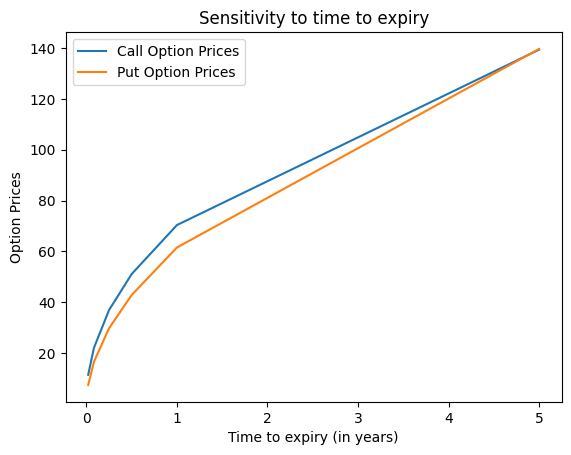

In [15]:
# Time range from 1 week to 5 years (all annualised)
expiryTimeRange = [5.0/252, 21.0/252, 0.25, 0.5, 1.0, 5.0]
callPricesForTime = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=time, \
                               intRate=zeroRate, divY=divYield, sigma=callAtmCalSigma) 
                      .price(optType='C') for time in expiryTimeRange]
putPricesForTime = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=time, \
                               intRate=zeroRate, divY=divYield, sigma=putAtmCalSigma) 
                      .price(optType='P') for time in expiryTimeRange]

# plot the time to expiry values against call & put prices
plt.plot(expiryTimeRange, callPricesForTime, label='Call Option Prices')
plt.plot(expiryTimeRange, putPricesForTime, label='Put Option Prices')
plt.xlabel('Time to expiry (in years)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to time to expiry')
plt.legend()

As we increase time we increase the uncertainty regarding the future price. Since uncertainty is to the options holder's benefit, the price of the option increases with time.

---

### Q2 (d) The sensitivity of the Black-Scholes option price to changes in the interest rate r. (e.g. r in the range 0% to 14%, in steps of 0.25%)

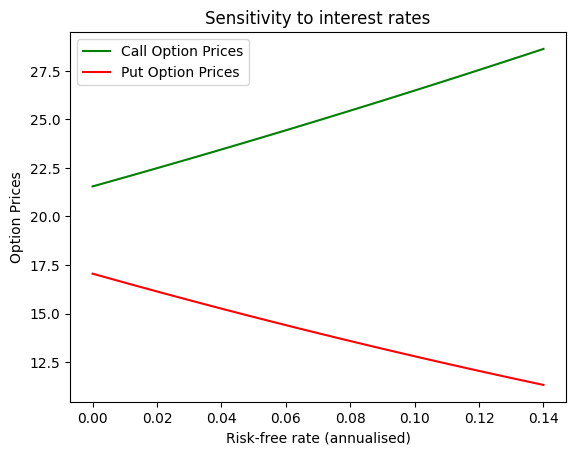

In [16]:
# Interest Rate range from 0% to 14% in steps of 0.25%
intRateRange = np.arange(0, 0.1425, 0.0025)

callPricesForInt = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=intR, divY=divYield, sigma=callAtmCalSigma) 
                      .price(optType='C') for intR in intRateRange]
putPricesForInt = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=intR, divY=divYield, sigma=putAtmCalSigma) 
                      .price(optType='P') for intR in intRateRange]

# plot the time to expiry values against call & put prices
plt.plot(intRateRange, callPricesForInt, label='Call Option Prices', color='green')
plt.plot(intRateRange, putPricesForInt, label='Put Option Prices', color='red')
plt.xlabel('Risk-free rate (annualised)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to interest rates')
plt.legend()

As mentioned earlier, call option prices have a positive relationship with the risk-free interest rates, whereas, put option prices genrally tend to fall with any rise in interest rates. This can be observed in the above sensitivity plot.


TODO: Compare and contrast the above results with regards to option theory and option hedging strategy.

---
---

### Q3 Compute and plot the intrinsic value function for both ATM call & put options

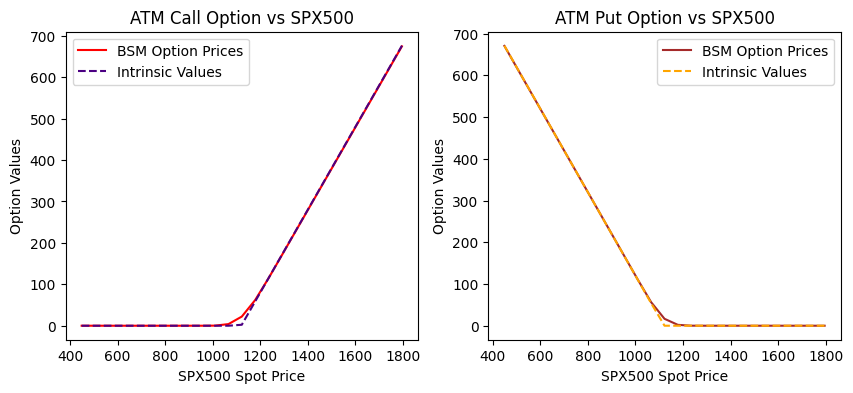

In [17]:
q3PctRange = np.round(np.arange(-0.6, 0.65, 0.05), decimals=2)
q3SpxSpotRange = [(1+pct) * spxSpot for pct in q3PctRange]

# compute call option values & their intrinsic values
q3CallPrices = [BsOption(spot=spot, strike=callAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=zeroRate, divY=divYield, sigma=callAtmCalSigma)
                .price(optType='C') for spot in q3SpxSpotRange]
q3CallIV = [max(spot-callAtmData.Strike, 0) for spot in q3SpxSpotRange]

# plot of call option values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(q3SpxSpotRange, q3CallPrices, label='BSM Option Prices', color='red')
plt.plot(q3SpxSpotRange, q3CallIV, label='Intrinsic Values', linestyle='dashed', color='indigo')
plt.xlabel('SPX500 Spot Price')
plt.ylabel('Option Values')
plt.title('ATM Call Option vs SPX500')
plt.legend()

# compute put option values & their intrinsic values
q3PutPrices = [BsOption(spot=spot, strike=putAtmData.Strike, time=timeToExpiryAnnualised, \
                               intRate=zeroRate, divY=divYield, sigma=putAtmCalSigma)
                .price(optType='P') for spot in q3SpxSpotRange]
q3PutIV = [max(putAtmData.Strike - spot, 0) for spot in q3SpxSpotRange]

# plot of put option values
plt.subplot(1, 2, 2)
plt.plot(q3SpxSpotRange, q3PutPrices, label='BSM Option Prices', color='brown')
plt.plot(q3SpxSpotRange, q3PutIV, label='Intrinsic Values', linestyle='dashed', color='orange')
plt.xlabel('SPX500 Spot Price')
plt.ylabel('Option Values')
plt.title('ATM Put Option vs SPX500')
plt.legend()

### Q4 Using a large sample of S&P500 returns up to your option trade date to fit a volatility model and use this model to forecast volatility over the lifetime of the option (the one month from the trade date to the expiry date).

### Compare your volatility forecast to the option implied volatility, based on this comparison or any other rationale that a trader on that date may have applied (rationale to be included in the report):
### i. construct an option spread to trade volatility using any subset of all of the options from the full traded set on your date.
### ii. Plot the payoff function of your option spread
### iii. In a small Table: Report the cost of the portfolio, the value on expiry of the index and the resulting P&L (using your payoff function at that expiry value).
### iv. Comment on your results.

Annualised volatility values (%) on option trade date: 18/03/2004 

┌────────────────────┬────────────────────┬─────────┬────────────────────────┬───────────────────────┐
│  SPX Forecast Vol  │  SPX Realised Vol  │   VIX   │  ATM Call Implied Vol  │  ATM Put Implied Vol  │
├────────────────────┼────────────────────┼─────────┼────────────────────────┼───────────────────────┤
│      14.4959       │      12.3191       │ 18.5300 │        17.0580         │        16.0270        │
└────────────────────┴────────────────────┴─────────┴────────────────────────┴───────────────────────┘


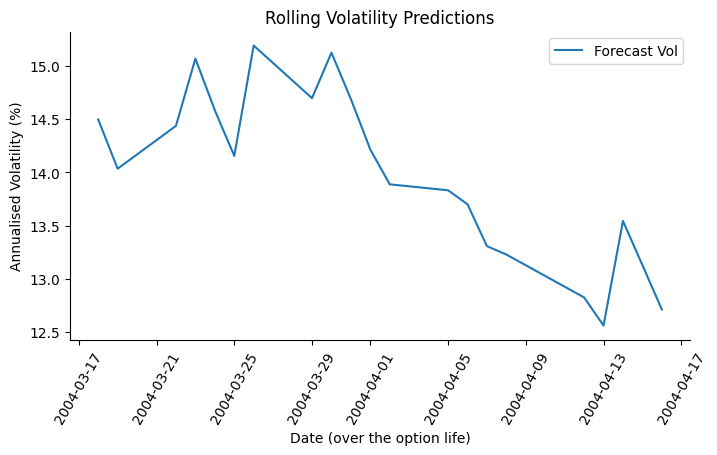

In [18]:
sampleSize = 3000

# adjusted spx data with pct returns & log returns
q4SpxData = spxData.copy()
q4SpxData['Return'] = q4SpxData['Adj Close'].pct_change() * 100
q4SpxData['Log Return'] = (np.log(q4SpxData['Adj Close']) - 
                            np.log(q4SpxData['Adj Close'].shift(1))) * 100 # rescale to facilitate optimisation
q4SpxData.dropna(inplace=True)
q4SpxData.reset_index(inplace=True, drop=True)
q4SpxData.set_index('Date', inplace=True, drop=True)

# Calculate volatility (realised) of SPX over the option time to expiry
volRealisedDaily = q4SpxData[q4SpxData.index >= tradeDate]['Return'].std() # daily
volRealisedAnnual = np.sqrt(252) * volRealisedDaily # annualised

# forecast volatility of SPX over option time to expiry using GARCH(1,1) model
rolling_predictions = []
test_size = 21
for i in range(test_size):
    train = q4SpxData['Return'][-(sampleSize + test_size):-(test_size-i)]
    gModel = arch_model(train, p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal', rescale=True)
    res = gModel.fit(disp='off')
    scale = res.scale
    pred = res.forecast(horizon=1, reindex=True)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]/np.power(scale, 2)) * np.sqrt(252))
volForecast = pd.Series(rolling_predictions, index=q4SpxData.index[-test_size:])

# Fetch VIX value on trade date 
vixData = pd.read_csv("input resources/VIX.csv")
vixData['Date'] = pd.to_datetime(vixData['Date'], infer_datetime_format=True, format='%d/%m/%Y')
vixValue = vixData[vixData.Date == tradeDate]['Adj Close'].item()

print('Annualised volatility values (%) on option trade date: ' + tradeDate.strftime("%d/%m/%Y") + ' \n\n' 
      + str(tabulate([[volForecast[0], volRealisedAnnual, vixValue, 
                       callAtmData['Implied Vol'] * 100, putAtmData['Implied Vol'] * 100]], 
                     headers = ['SPX Forecast Vol', 'SPX Realised Vol', 'VIX', 'ATM Call Implied Vol', 
                                'ATM Put Implied Vol'], 
               tablefmt = 'simple_grid', stralign='center', numalign='center', floatfmt=".4f")))
fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(volForecast, label='Forecast Vol')
plt.title('Rolling Volatility Predictions')
plt.xlabel('Date (over the option life)')
plt.xticks(rotation=60)
plt.ylabel('Annualised Volatility (%)')
plt.legend()

We can observe from the above table that the forecasted SPX volatility (14.496 %) is lesser than the VIX value (18.53 %) on our trade date (18-03-2004). This indicates that the general market has priced in higher volatility levels and appears to be overvalued as on the trade date. It's further supported by the higher implied volatility values observed for both of our ATM call and put options, i.e the option prices have factored in higher volatility values, thus shooting up their premiums which leaves room for some price correction over time to expiry.

Given the scenario, we choose to construct an option spread portfolio to trade the volatility using a **Short Straddle** strategy where we short both, ATM call and ATM put options on our trade date. The rationale for this strategy is we expect Implied Vol to reduce significantly by option expiry, allowing most if not all of the premium received on the short put and short call positions to be retained.
   

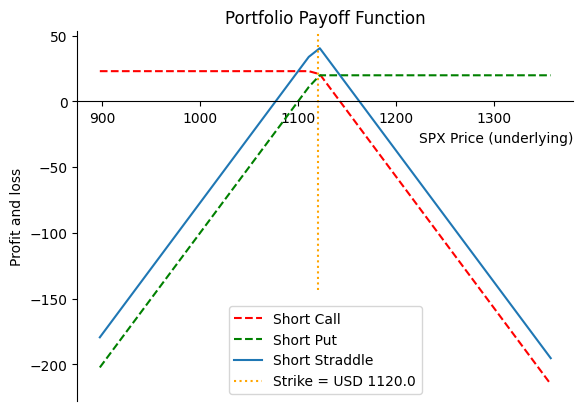

In [19]:
# series of underlying SPX prices
q4PctRange = np.round(np.arange(-0.2, 0.22, 0.01), decimals=2)
q4SpxSpotRange = [(1+pct) * spxSpot for pct in q4PctRange]

# define payoff functions
shortCallPayoff = lambda S, K, premium : premium - np.maximum(S - K, 0.0)
shortPutPayoff = lambda S, K, premium : premium - np.maximum(K - S, 0.0)
shortStraddlePayoff = shortCallPayoff(q4SpxSpotRange, callAtmData['Strike'], callAtmPrice) + shortPutPayoff(q4SpxSpotRange, putAtmData['Strike'], putAtmPrice)

# plot the payoff functions
fig, ax = plt.subplots()
ax.spines[['top', 'right']].set_visible(False) # remove top and right borders
ax.spines['bottom'].set_position('zero')
ax.plot(q4SpxSpotRange, shortCallPayoff(q4SpxSpotRange, callAtmData['Strike'], callAtmPrice),
        '--', label='Short Call', color='r')
ax.plot(q4SpxSpotRange, shortPutPayoff(q4SpxSpotRange, putAtmData['Strike'], putAtmPrice), 
        '--', label='Short Put', color='g')
ax.plot(q4SpxSpotRange, shortStraddlePayoff, label='Short Straddle')
ax.axvline(putAtmData['Strike'], 0.3, 1, ls=':', label='Strike = USD {}'.format(putAtmData['Strike']), color='orange')
plt.title('Portfolio Payoff Function')
plt.xlabel('SPX Price (underlying)', loc='right')
plt.ylabel('Profit and loss')
plt.legend()

**Maximum Profit**

Overall portfolio profit potential is limited to the total premiums (\$ 42.7) received less any transaction costs (transactions not factored in the above plot). The maximum profit is earned if the short straddle is held to expiration and the index price closes exactly at the strike price (USD 1120.0), i.e both the options expire worthless.


**Maximum Loss**

As we can infer from the above plot, potential loss is unlimited on the upside because the index price can rise indefinitely. There's a substantial downside risk too since the index prices can crash significantly from current levels to reach an absolute zero (highly unlikely for an index). 

There are 2 potential breakeven points:
1. Strike price plus total premium => 1120.0 + 42.7 = \$ 1162.7
2. Strike price minus total premium => 1120.0 - 42.7 = \$ 1077.3

So, if the index price on expiry date is within these bounds, then our portfolio will have a positive return and moneyness property of ITM.

In [20]:
# computing PnL on option expiry
plOnExpiry = shortCallPayoff(q4SpxData[-1:]['Adj Close'].item(), callAtmData['Strike'], callAtmPrice) 
+ shortPutPayoff(q4SpxData[-1:]['Adj Close'].item(), putAtmData['Strike'], putAtmPrice)

print(str(tabulate([['Transaction/Margin costs if any (no buy costs since we are selling)', 
                     q4SpxData[-1:]['Adj Close'].item(), plOnExpiry]], 
                     headers = ['Portfolio Cost', 'SPX spot on expiry', 'P/L on expiry'], 
               tablefmt = 'simple_grid', stralign='center', numalign='center', floatfmt=".4f")))

┌─────────────────────────────────────────────────────────────────────┬──────────────────────┬─────────────────┐
│                           Portfolio Cost                            │  SPX spot on expiry  │  P/L on expiry  │
├─────────────────────────────────────────────────────────────────────┼──────────────────────┼─────────────────┤
│ Transaction/Margin costs if any (no buy costs since we are selling) │      1134.6100       │     8.3015      │
└─────────────────────────────────────────────────────────────────────┴──────────────────────┴─────────────────┘
